In [1]:
import os

# Set up the path to the data.
data_path = '/vol/bitbucket/az620/radiotherapy/data'

if os.path.exists(data_path):
    print("The path exists.")
    print('The relevant contents are...')
    for x in sorted(os.listdir(data_path)): 
        if 'nnUNet' in x: print(f'   {x}')
else:
    print("The path does not exist.")

The path exists.
The relevant contents are...
   nnUNet_inference
   nnUNet_predictions_bglocker
   nnUNet_preprocessed
   nnUNet_raw
   nnUNet_results


In [2]:
# Each anatomical structure has a unique identifier.
id_anorectum = 'Dataset001_Anorectum'
id_bladder = 'Dataset002_Bladder'
id_ctvn = 'Dataset003_CTVn'
id_ctvp = 'Dataset004_CTVp'
id_parametrium = 'Dataset005_Parametrium'

In [3]:
import json

file_path = os.path.join(data_path, 'nnUNet_raw', id_anorectum, 'dataset.json')

with open(file_path, 'r') as file:
    data = json.load(file)

data

{'channel_names': {'0': 'CT'},
 'labels': {'background': 0, 'anorectum': 1},
 'numTraining': 100,
 'file_ending': '.nii.gz',
 'overwrite_image_reader_writer': 'SimpleITKIO'}

## Run Total Segmentator for the Bladder case

In [4]:
import nibabel as nib
from totalsegmentator.python_api import totalsegmentator

In [5]:
import os
bladder_raw_data_x = os.path.join(data_path, 'nnUNet_raw', id_bladder, 'imagesTr')
bladder_output_path = os.path.join(data_path, 'TotalSegmentator', id_bladder, 'imagesTs')

os.makedirs(bladder_output_path, exist_ok=True)

for x in sorted(os.listdir(bladder_raw_data_x)):
    if x in os.listdir(bladder_output_path):
        print(f'{x} already processed')
        continue
    
    print(f'processing {x}')
    relative_path = os.path.join(bladder_raw_data_x, x)
    output_path = os.path.join(bladder_output_path, x)

    img = nib.load(relative_path)
    output_img = totalsegmentator(img, body_seg=True, roi_subset=['urinary_bladder'])

    nib.save(output_img, output_path)

zzAMLART_001_0000.nii.gz already processed
zzAMLART_002_0000.nii.gz already processed
zzAMLART_003_0000.nii.gz already processed
zzAMLART_004_0000.nii.gz already processed
zzAMLART_005_0000.nii.gz already processed
zzAMLART_006_0000.nii.gz already processed
zzAMLART_007_0000.nii.gz already processed
zzAMLART_008_0000.nii.gz already processed
zzAMLART_009_0000.nii.gz already processed
zzAMLART_010_0000.nii.gz already processed
zzAMLART_011_0000.nii.gz already processed
zzAMLART_012_0000.nii.gz already processed
zzAMLART_013_0000.nii.gz already processed
zzAMLART_014_0000.nii.gz already processed
zzAMLART_015_0000.nii.gz already processed
zzAMLART_016_0000.nii.gz already processed
zzAMLART_017_0000.nii.gz already processed
zzAMLART_018_0000.nii.gz already processed
zzAMLART_019_0000.nii.gz already processed
zzAMLART_020_0000.nii.gz already processed
zzAMLART_021_0000.nii.gz already processed
zzAMLART_022_0000.nii.gz already processed
zzAMLART_023_0000.nii.gz already processed
zzAMLART_02

## Get the performance metrics

In [6]:
import SimpleITK as sitk
import numpy as np
import tqdm
from tqdm import tqdm

overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

bladder_y_path = os.path.join(data_path, 'nnUNet_raw', id_bladder, 'labelsTr')

dice = []
jaccard = []
volume_similarity = []


for ypred, y in tqdm(zip(sorted(os.listdir(bladder_output_path)), sorted(os.listdir(bladder_y_path))), desc='Calculating metrics', ncols=100):
    y_img_sitk = sitk.ReadImage(os.path.join(bladder_y_path, y))
    ypred_img_sitk = sitk.ReadImage(os.path.join(bladder_output_path, ypred))

    overlap_measures_filter.Execute(y_img_sitk, ypred_img_sitk)

    dice.append(overlap_measures_filter.GetDiceCoefficient())
    jaccard.append(overlap_measures_filter.GetJaccardCoefficient())
    volume_similarity.append(overlap_measures_filter.GetVolumeSimilarity())


Calculating metrics: 100it [00:34,  2.86it/s]


In [7]:
import numpy as np

def calculate_stats(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    quartiles = np.percentile(data, [25, 50, 75])
    
    return mean, std_dev, quartiles

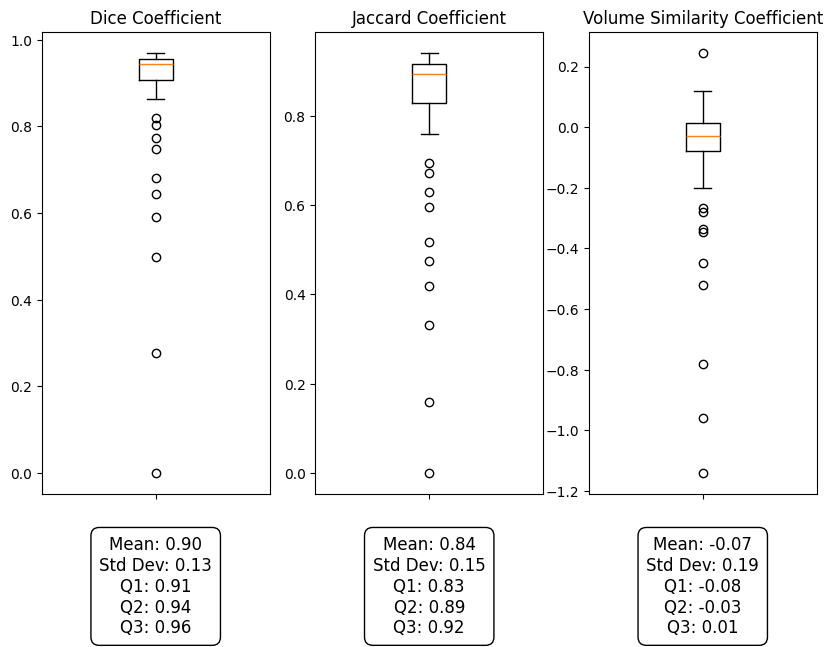

In [8]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))

axes[0].boxplot(dice)
axes[0].title.set_text('Dice Coefficient')
axes[0].set_xticklabels([])

axes[1].boxplot(jaccard)
axes[1].title.set_text('Jaccard Coefficient')
axes[1].set_xticklabels([])

axes[2].boxplot(volume_similarity)
axes[2].title.set_text('Volume Similarity Coefficient')
axes[2].set_xticklabels([])

# Add a text box at the bottom
# fig.text(0.5, 0.05, 'This is a text box', ha='center', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

for ax, plotted_data in zip(axes, [dice, jaccard, volume_similarity]):
    mean, std, quartiles = calculate_stats(plotted_data)

    text = f'Mean: {mean:.2f}\nStd Dev: {std:.2f}\nQ1: {quartiles[0]:.2f}\nQ2: {quartiles[1]:.2f}\nQ3: {quartiles[2]:.2f}'

    ax.text(0.5, -0.2, text, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


plt.show()


# DICE 

$\text{DICE} = \frac{2|S_g\cap S_p|}{|S_g|+|S_p|}$ Therefore, the best score you can get on DICE is 1

# Jaccard Index

$  \text{JAC} = \frac{TP}{TP+FP+FN} = \frac{|S_g\cap S_p|}{|S_g \cup S_p|} \iff \frac{DICE}{2 - DICE}$ Therefore, the best score you can get on Jaccard is 1

# Volume Similairty Index

$  \text{Relative Volume Difference (RVD)} = \bigg| \frac{|S_g|-|S_p|}{|S_g|}\bigg|$ Therefore, the best score you can get is 0 when $S_g = S_p$

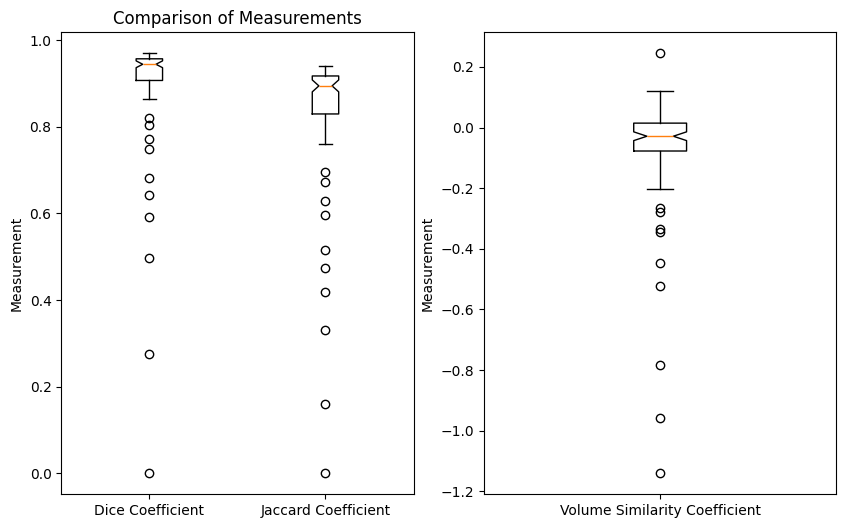

In [9]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))


# Plot the boxplot
axes[0].boxplot([dice, jaccard], notch=True)

# Set the x-axis labels
axes[0].set_xticklabels(['Dice Coefficient', 'Jaccard Coefficient'])

# Set the y-axis label
axes[0].set_ylabel('Measurement')

# Set the title
axes[0].set_title('Comparison of Measurements')

axes[1].boxplot(volume_similarity, notch=True)
axes[1].set_xticklabels(['Volume Similarity Coefficient'])
axes[1].set_ylabel('Measurement')

# Show the plot
plt.show()